In [462]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines
from sklearn.preprocessing import normalize as norm

In [463]:
FILE_PATH = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0001_newcut.root" #Relative file path
file1 = uproot.open(FILE_PATH)
file1["tree"].show()

FILE_PATH_2 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0002_newcut.root" #Relative file path
file2 = uproot.open(FILE_PATH_2)

FILE_PATH_3 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0003_newcut.root" #Relative file path
file3 = uproot.open(FILE_PATH_3)

FILE_PATH_4 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0004_newcut.root" #Relative file path
file4 = uproot.open(FILE_PATH_4)

FILE_PATH_5 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0005.root" #Relative file path
file5 = uproot.open(FILE_PATH_5)

FILE_PATH_6 = "../Dati/Run_Na_ortho_468ps_trig_on_1200keV_Data_5_27_2024_Ascii_0000.root"
file6=uproot.open(FILE_PATH_6)

FILE_PATH_7 = "../Dati/Ortopositronio/Run_ortho2_468ps_Data_5_31_2024_Ascii_0000.root"
file7=uproot.open(FILE_PATH_7)

FILE_PATH_8 = "../Dati/Run_ortho2_468ps_Data_5_31_2024_Ascii_0001.root"
file8=uproot.open(FILE_PATH_8)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [464]:
print(type(file1["tree"]["base"].array()))
bl=file1["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file1["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 16]
[16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [465]:
def extract_data(file):
    baselines = np.array(file["tree"]["base"])[1:-1]
    charges = np.array(file["tree"]["charge"])[1:-1]
    amp = np.array(file["tree"]["amp"])[1:-1]
    lead_edge = np.array(file["tree"]["letime"])[1:-1]
    t_edge = np.array(file["tree"]["tetime"])[1:-1]
    channel = np.array(file["tree"]["ch"])[1:-1]
    waveform = np.array(file["tree"]["pshape"])[1:-1]
    
    return baselines, charges, amp, lead_edge, t_edge, channel, waveform

# Use the function for each batch
baselines1, charges1, amp1, lead_edge1, t_edge1, channel1, waveform1 = extract_data(file1)
baselines2, charges2, amp2, lead_edge2, t_edge2, channel2, waveform2 = extract_data(file2)
baselines3, charges3, amp3, lead_edge3, t_edge3, channel3, waveform3 = extract_data(file3)
baselines4, charges4, amp4, lead_edge4, t_edge4, channel4, waveform4 = extract_data(file4)
baselines5, charges5, amp5, lead_edge5, t_edge5, channel5, waveform5 = extract_data(file5)
baselines6, charges6, amp6, lead_edge6, t_edge6, channel6, waveform6 = extract_data(file6)
baselines7, charges7, amp7, lead_edge7, t_edge7, channel7, waveform7 = extract_data(file7)
baselines8, charges8, amp8, lead_edge8, t_edge8, channel8, waveform8 = extract_data(file8)

#concatenate arrays

baselines=np.concatenate((baselines1, baselines2, baselines3, baselines4, baselines5, baselines6, baselines7, baselines8))
charges = np.concatenate((charges1, charges2, charges3,charges4, charges5, charges6, charges7, charges8))
amp = np.concatenate((amp1, amp2, amp3, amp4, amp5, amp6, amp7, amp8))
lead_edge = np.concatenate((lead_edge1, lead_edge2, lead_edge3,lead_edge4, lead_edge5, lead_edge6, lead_edge7, lead_edge8))
t_edge = np.concatenate((t_edge1, t_edge2, t_edge3,t_edge4, t_edge5, t_edge6, t_edge7, t_edge8))
channel = np.concatenate((channel1, channel2, channel3,channel4, channel5, channel6, channel7, channel8))
waveform = np.concatenate((waveform1,waveform2, waveform3,waveform4, waveform5, waveform6, waveform7, waveform8))



In [466]:
#carico la matrice degli offset
def load_matrix(filename):
    return(np.load(filename))

loaded=load_matrix('offset_matrix.npz')
matrix_loaded = loaded['arr_0']
print(matrix_loaded)

[[ 0.          1.97790006  8.30515642  5.13880779  3.25188705  0.60127363
   4.63887604  2.23860842  2.96122492  1.7662929   0.08214686  2.61439973
   5.75674346  0.          2.66775925  2.25991482]
 [-1.97790006  0.          6.65268982  3.35018406  1.62865816 -1.42310493
   3.35363686 -0.09357444  1.55745866 -0.03231273 -2.23996373  0.60939011
   4.72326522  0.          2.19416517  0.31886456]
 [-8.30515642 -6.65268982  0.         -3.16529453 -4.96229802 -7.97382458
  -3.7849691  -6.49220942 -5.17749042 -6.89120561 -8.45633986 -5.88758847
  -2.87454218 -1.5810066  -4.69470296 -6.61630156]
 [-5.13880779 -3.35018406  3.16529453  0.         -1.74554839 -4.80185979
  -0.55825317 -3.03106198 -1.99820973 -3.57586387 -4.96672159 -2.73908285
   0.62833715  0.         -1.49089966 -3.16862866]
 [-3.25188705 -1.62865816  4.96229802  1.74554839  0.         -3.28007198
   1.04874026 -1.23946888 -0.16332661 -2.06401735 -3.11165703 -1.13443192
   2.46599326  0.         -0.9021026  -1.78743256]
 [-0.

In [467]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(24476,)
(24476,)
24476


In [468]:
len(np.where(amp[0]>-1.2)[0])==16

True

In [469]:
print(channel)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 ... array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
           dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
       dtype=int32)                                                 ]


In [470]:

mask=[len(np.where(amp[i]>-1.2)[0])==16 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, True, False, False, True, False, False, True, True, True, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, False, True, True, True, True, False, True, False, False, True, True, False, True, True, False, True, False, True, True, True, True, True, False, False, True, True, True, False, True, True, False, False, False, False, True, True, False, False, True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, False, True, False, True, True, False, False, Tru

In [471]:
print(len(amp))
Nev=len(amp)

13121


(13121,)
channel: 0 baseline: 7.6e-05 charge -1.064 lead_edge 250.959 trailing_edge 248.543
channel: 1 baseline: 0.000381 charge -0.423 lead_edge 370.578 trailing_edge 368.535
channel: 2 baseline: 0.000114 charge 0.2 lead_edge 29.735 trailing_edge 25.046
channel: 3 baseline: -0.000229 charge 1.659 lead_edge 332.058 trailing_edge 330.767
channel: 4 baseline: 0.000229 charge 0.343 lead_edge 35.509 trailing_edge 34.767
channel: 5 baseline: 0.0 charge 1.75 lead_edge 128.891 trailing_edge 127.469
channel: 6 baseline: 0.0 charge -0.538 lead_edge 303.118 trailing_edge 298.937
channel: 7 baseline: 0.000419 charge -2.517 lead_edge 351.031 trailing_edge 348.83
channel: 8 baseline: -0.000152 charge 3.294 lead_edge 89.125 trailing_edge 88.207
channel: 9 baseline: 3.8e-05 charge -483.089 lead_edge 0.003 trailing_edge 0.003
channel: 10 baseline: -0.008731 charge 4.496 lead_edge 264.481 trailing_edge 260.488
channel: 11 baseline: 0.0 charge -1.779 lead_edge 193.876 trailing_edge 189.309
channel: 12 b

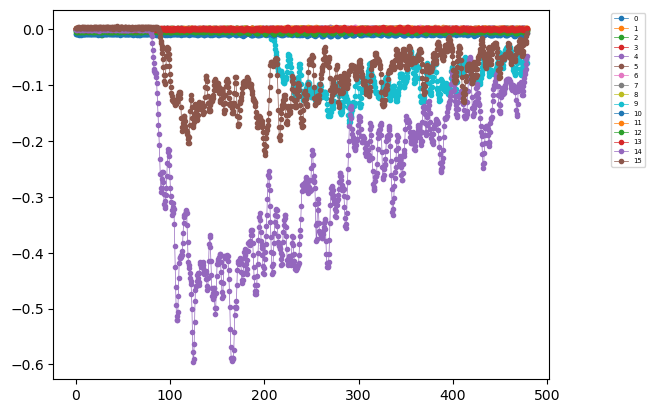

In [472]:
print(waveform.shape)
event=521
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[1,2,7,12]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    #plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    #plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [473]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-100)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


#print(true_channels)
#print(true_charges)


#devo selezionare le annichilazioni back to back e isolarle dal resto


In [474]:
#eventi con 3 gamma
n_photons=[len(true_channels[i]) for i in range(Nev)]
n_photons=np.array(n_photons)
three_gamma_events=np.where(n_photons == 4)[0] #eventi con 4 fotoni totali (ortopositronio?)
print(three_gamma_events)
four_gamma_events=np.where(n_photons == 5)[0]
print(four_gamma_events)

[   30    44    58    75    77    85    93   107   111   116   128   129
   131   141   191   218   241   251   254   294   305   309   344   362
   368   369   372   378   381   385   393   402   429   438   446   450
   508   517   536   537   541   556   575   580   597   606   633   642
   668   674   678   681   684   699   759   760   770   779   790   805
   813   815   829   840   937   940   979   993  1043  1128  1150  1169
  1175  1189  1206  1238  1249  1259  1268  1277  1291  1302  1314  1324
  1355  1362  1369  1376  1378  1396  1399  1413  1454  1474  1477  1488
  1499  1521  1534  1556  1570  1588  1599  1603  1605  1625  1629  1633
  1634  1641  1644  1653  1666  1723  1735  1758  1806  1807  1818  1823
  1833  1834  1843  1864  1901  1902  1906  1943  1963  1968  1973  2000
  2036  2049  2080  2082  2090  2112  2134  2168  2176  2205  2209  2210
  2225  2231  2245  2255  2278  2285  2304  2310  2321  2327  2344  2370
  2390  2412  2413  2444  2447  2473  2482  2484  2

In [475]:
shift = 5

def times_from_waveforms(wf_narr, n_conv, threshold):

    lenghts = []
    wf_arr = []

    for evt in range(len(wf_narr)):
        for ch in range(len(wf_narr[evt])):
            wf_arr.append(wf_narr[evt][ch])
        lenghts.append(len(wf_narr[evt]))


    wf_arr = np.array(wf_arr)
    wf_arr = -norm(-np.array(wf_arr), norm = "max", axis = 1, copy = True, return_norm = False)

    ledges = np.zeros(wf_arr.shape[0])


    for evt in range(len(wf_arr)):

        bsl = wf_arr[evt][0:32].mean()
        wf_arr[evt] = np.convolve(wf_arr[evt], [1/n_conv] * n_conv, mode = "same") - bsl

        ledge= np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]
        ledges[evt]=np.interp(threshold,  [wf_arr[evt][ledge-shift], wf_arr[evt][ledge+shift]], [ledge-shift, ledge+shift])*0.468

        #ledges[evt] = np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]

        

        #plt.plot(range(1024), wf_arr[evt])
        #plt.plot([ledges[evt]] * 2, [ -1, 0])


    ledg_arr = []
    k = 0
    for i in range(len(lenghts)):
        tmp_list = []
        for j in range(lenghts[i]):
            tmp_list.append(ledges[k])
            k += 1
        ledg_arr.append(tmp_list)


    return ledg_arr

print(0.468*1024) #finestra di sampling di wavecatcher



479.232


In [503]:
#funzione per filtrare le coincidenze casuali

def filter_times(times, sigma):
    filtered_times = []
    threshold = 3 * sigma

    for time in times:
        if any(abs(time - other_time) <= threshold for other_time in times if other_time != time):
            filtered_times.append(time)
    
    return filtered_times

/Users/elenadesantis/anaconda3/envs/myrootenv_new/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


26
26
111
236
247
247
309
309
326
326
336
336
419
419
698
698
703
703
804
804
1249
1249
1499
1499
1807
1807
1889
1963
2080
2080
2276
2276
2285
2285
2597
2597
2789
2789
2901
2901
2987
3078
3150
3209
3209
3469
3469
3624
3771
3771
3917
3917
4106
4106
4157
4229
4245
4245
4326
4326
4339
4339
4433
4433
4499
4910
4915
4915
4999
5019
5028
5214
5214
5219
5219
5265
5265
5353
5353
5503
5503
5518
5518
5633
5633
5920
5920
5932
5932
6071
6071
6172
6322
6322
6661
6661
6726
6726
6729
6730
6730
6861
6984
6984
7121
7121
7151
7231
7482
7482
7638
7864
8219
8219
8238
8238
8260
8260
8266
8266
8271
8271
8369
8518
8773
8773
8786
8786
8818
8818
8872
8872
8973
8973
8986
9475
9504
9504
9669
9738
9738
9768
9768
9829
9829
9886
10278
10278
10432
10432
10445
10445
10742
10742
10755
10759
10861
10861
11141
11431
11431
11536
11536
11675
11675
11869
11869
11956
11963
12087
12087
12454
12454
12719
12719
12978
13062
13062
13110
13110


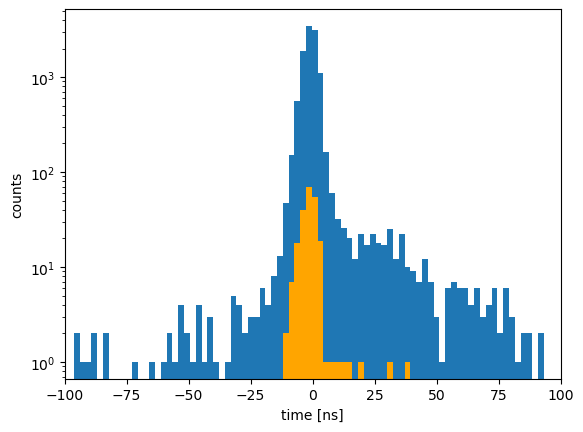

In [551]:

good_t_arr=[]
time_diff=[]
back_to_back_times=[] #inserirò i tempi degli eventi back to back
treshold=-0.01 #soglia fissa
btb_pairs=[np.array([4,5]), np.array([6, 7]), np.array([8, 9]), np.array([10,11]), np.array([12, 13]), np.array([14, 15])]
timing_res = 1.7 #la nostra risoluzione temporale


arr_times_all=times_from_waveforms(true_waveforms,30, treshold)


for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=arr_times_all[ev] #calcolo tempi di arrivo dei segnali
    ev_is_good=(t_arr[index_1200]!=0)
    if(ev_is_good):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        #add offset
        t_diff = [t_diff[i] - matrix_loaded[true_channels[ev][i]][true_channels[ev][index_1200]] for i in range(len(t_diff))]
        t_diff.pop(index_1200)
        
        #check if the low-energy photons are actually in coincidence
        t_diff=filter_times(t_diff, timing_res)
        if(len(t_diff) >=2):
            time_diff.append(t_diff)
            if(np.mean(np.array(t_diff)) < -80): print(ev)


        # print(true_channels[ev])
        if(np.mean(np.array(t_diff)) < -25): print(ev)
    
    
    gamma_channels = [ch for i, ch in enumerate(true_channels[ev]) if i != index_1200] #canali che hanno visto i fotoncini di annichilazione
    #print(gamma_channels)
    for pair in btb_pairs:
        if np.array_equal(sorted(gamma_channels), sorted(pair)):
            back_to_back_times.append(t_diff)
            break  # Exit loop if a match is found

    
        

#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff if -100< np.mean(np.array(times)) <100]
mean_time_diff=np.array(mean_time_diff)

btb_mean_time_diff =[np.mean(np.array(times)) for times in back_to_back_times]
btb_mean_time_diff = np.array(btb_mean_time_diff)

bins_array = np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=2.34) # uncomment to go back to even bins

outofwindow=np.where(mean_time_diff > 0.468*1024)[0]
#print(outofwindow)

bin_T, edgesT, _=plt.hist(mean_time_diff, bins=bins_array)
_=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')
plt.yscale('log')

#pop away the first bin
#bin_T=bin_T[1:-1]
#edgesT=edgesT[1:-1]  #l'ultimo bin eccede la finestra di wavecatcher


#Nbins = len(np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=4))
Nbin=len(bin_T)


centersT = np.convolve(edgesT, [0.5, 0.5], "valid")
#plt.yscale('log')
plt.xlim(-100, 100)
plt.xlabel('time [ns]')
plt.ylabel('counts')

#evaluate errors

errT = np.sqrt(bin_T)
#print(edgesT)



In [531]:
#proviamo a fittare
import lmfit
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, ConstantModel, LorentzianModel, VoigtModel, ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [544]:

# Define the truncated exponential function
def myexp(x, amplitude, decay):
    x = np.asarray(x)  # Ensure x is a NumPy array
    result = np.zeros_like(x)
    mask = x >= 0
    result[mask] = amplitude * np.exp(-x[mask] / decay)
    return result



# Create models
exp1 = Model(myexp, independent_vars=['x'], prefix='e1_')
exp2 = Model(myexp, independent_vars=['x'], prefix='e2_')
gauss1 = GaussianModel(prefix='g1_')
#offset1 = StepModel(form = "logistic", prefix = "s1_")*(1 - StepModel(form = "logistic", prefix = "s2_"))
offset1 = ConstantModel(prefix='c1_')
#vincolo i parmetri della sigmoide:

#gauss1 = LorentzianModel(prefix='g1_')
#gauss1 = VoigtModel(prefix='g1_')

# Combine models
model = exp1 + exp2 + gauss1 + offset1


# Initialize parameters
params = gauss1.guess(bin_T, x=centersT)
params.update(exp1.make_params(amplitude=1000, decay=3))
params.update(exp2.make_params(amplitude=1000, decay=100))
params.update(offset1.make_params(c=0.5))

# Update parameters
params["e1_amplitude"].min = 0
params["e2_amplitude"].min = 0
#params["g1_center"].set(min=-0.7, max=0.7)
params["e2_decay"].set(value=142)

# Ensure all parameters are properly initialized
#params["e1_amplitude"].set(value=1000, min=0)
#params["e1_decay"].set(value=1, min=0)
params["e2_amplitude"].set(value=500)
params["e2_decay"].set(value=100, min=0)
params["g1_amplitude"].set(value=2000, min=10)
params["g1_center"].set(value=0)
params["g1_sigma"].set(value=3, min=0)
params["c1_c"].max = 2.5

result = model.fit(bin_T, params, x=centersT, weights=1 / errT, nan_policy='omit')

# Print fit report
print(result.fit_report())



[[Model]]
    (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(gaussian, prefix='g1_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 217
    # data points      = 59
    # variables        = 8
    chi-square         = 182.552286
    reduced chi-square = 3.57945659
    Akaike info crit   = 82.6404520
    Bayesian info crit = 99.2607516
    R-squared          = 0.99999271
[[Variables]]
    g1_amplitude:  22901.1028 +/- 1211.64464 (5.29%) (init = 2000)
    g1_center:    -1.08943502 +/- 0.17194889 (15.78%) (init = 0)
    g1_sigma:      2.70362554 +/- 0.08183570 (3.03%) (init = 3)
    g1_fwhm:       6.36655151 +/- 0.19270835 (3.03%) == '2.3548200*g1_sigma'
    g1_height:     3379.24704 +/- 125.133643 (3.70%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    e1_amplitude:  1033.94948 +/- 1133.17813 (109.60%) (init = 1000)
    e1_decay:      1.01106006 +/- 1.83960999 (181.95%) (init = 3)
    e2_amplitude:  4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


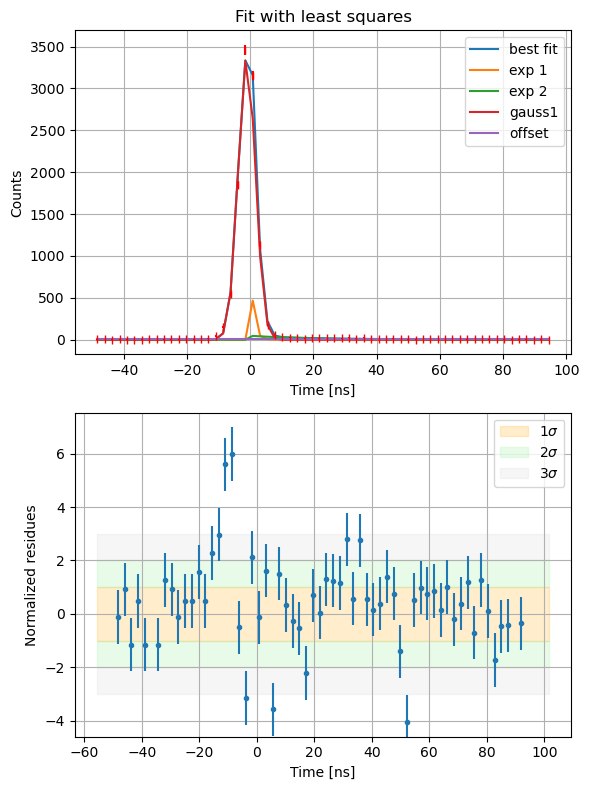

In [545]:
#plot del fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')
ax1.plot(centersT, comps['g1_'], label='gauss1')
ax1.plot(centersT, comps['c1_'], label='offset')


ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(0, 100)
ax1.grid()

residueT = bin_T - result.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(0, 100)
ax1.set_title('Fit with least squares')
fig.tight_layout()
plt.show()

In [550]:
print(len(mean_time_diff))

10997


In [546]:
emcee_kws = dict(steps=10000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee = model.fit(data=bin_T, x=centersT, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [319.18598118 314.18538516 201.17142935 718.5233192  573.5764484
 110.59706474 380.43161285 328.20072724 160.67668761]


In [547]:
print(result_emcee.fit_report())

[[Model]]
    (((Model(myexp, prefix='e1_') + Model(myexp, prefix='e2_')) + Model(gaussian, prefix='g1_')) + Model(constant, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1000000
    # data points      = 62
    # variables        = 9
    chi-square         = 5068.88378
    reduced chi-square = 95.6393166
    Akaike info crit   = 291.031975
    Bayesian info crit = 310.176184
    R-squared          = 0.99979761
[[Variables]]
    g1_amplitude:  23560.9763 +/- 22.0693179 (0.09%) (init = 22901.1)
    g1_center:    -0.91605813 +/- 0.00298592 (0.33%) (init = -1.089435)
    g1_sigma:      2.66121114 +/- 0.00204204 (0.08%) (init = 2.703626)
    g1_fwhm:       6.26667322 == '2.3548200*g1_sigma'
    g1_height:     3532.02718 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    e1_amplitude:  1014.65927 +/- 216.818056 (21.37%) (init = 1033.949)
    e1_decay:      0.58905913 +/- 0.09005588 (15.29%) (init = 1.01106)
    e2_amplitude:  23.7506490 +/- 1.293

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


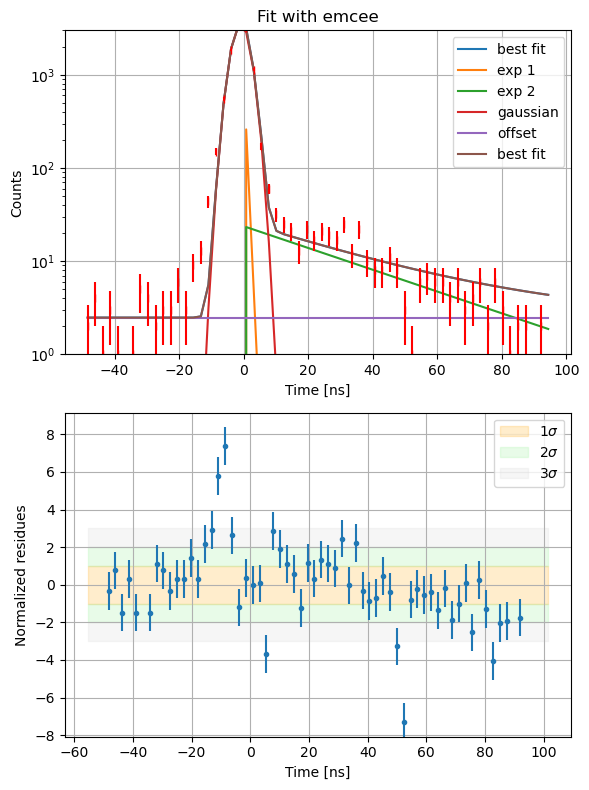

In [549]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result_emcee.eval_components() 
ax1.plot(centersT, result_emcee.best_fit, label='best fit')                       #Plotto il best fit + le componenti
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')
ax1.plot(centersT, comps['g1_'], label='gaussian')
ax1.plot(centersT, comps['c1_'], label='offset')
ax1.plot(centersT, result_emcee.best_fit, label='best fit')

ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
#ax1.set_xlim(0, 200)
ax1.grid()

residueT = bin_T - result_emcee.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
ax1.set_yscale('log')
ax2.legend()
ax1.set_ylim(1, 3000)
ax1.set_title('Fit with emcee')
fig.tight_layout()
plt.show()

nan
[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 16
    # variables        = 2
    chi-square         = 218.000000
    reduced chi-square = 15.5714286
    Akaike info crit   = 45.7905014
    Bayesian info crit = 47.3356789
    R-squared          = 0.97462292
##  Warning: uncertainties could not be estimated:
    e1_amplitude:  at initial value
    e1_amplitude:  at boundary
    e1_decay:      at initial value
[[Variables]]
    e1_amplitude:  1.0658e-14 (init = 1.059489e-14)
    e1_decay:      4.00000000 (init = 4)
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [276.34498899          nan  68.36939298]


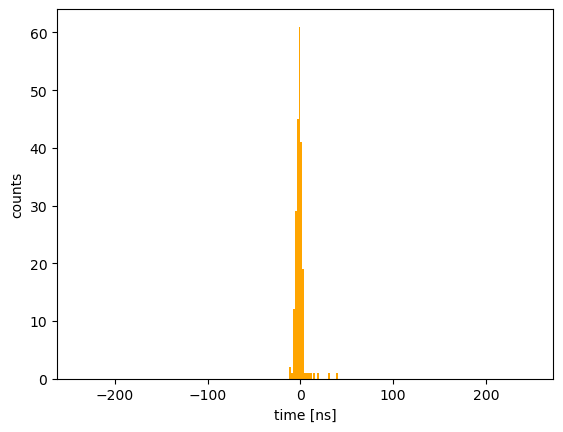

In [489]:
#fitto solo la componente back to back

bin_btb, edges_btb, _=plt.hist(btb_mean_time_diff, bins=bins_array, color='orange')

print(np.min(btb_mean_time_diff))

#bin_btb=bin_btb[1:-1]
#edges_btb=edges_btb[1:-1]  

centers_btb = np.convolve(edges_btb, [0.5, 0.5], "valid")
plt.xlabel('time [ns]')
plt.ylabel('counts')
err_btb = np.sqrt(bin_btb)

exp1   = ExponentialModel(prefix='e1_')

model = exp1 

params = exp1.guess(bin_btb, x=centers_btb)  
params["e1_amplitude"].min = 0
params["e1_decay"].set(value=4)

result = model.fit(bin_btb, params, x = centers_btb, weights = 1 / err_btb,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_btb = model.fit(data=bin_btb, x=centers_btb, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

In [490]:
print(result_emcee_btb.fit_report())

[[Model]]
    Model(exponential, prefix='e1_')
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 243
    # variables        = 3
    chi-square         = 2149.32826
    reduced chi-square = 8.95553441
    Akaike info crit   = 535.703353
    Bayesian info crit = 546.182538
    R-squared          = 0.74979963
[[Variables]]
    e1_amplitude:  0.89782354 +/- 0.15447493 (17.21%) (init = 1.065814e-14)
    e1_decay:     -4.4757e+17 +/- 5.922e+152 (132307591642608905366160948902555927730436306774608492747742664243722541607489623560096283335350437805415418400928053703036898079563317248.00%) (init = 4)
    __lnsigma:     0.69274661 +/- 6.0473e-04 (0.09%) (init = -2.302585)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


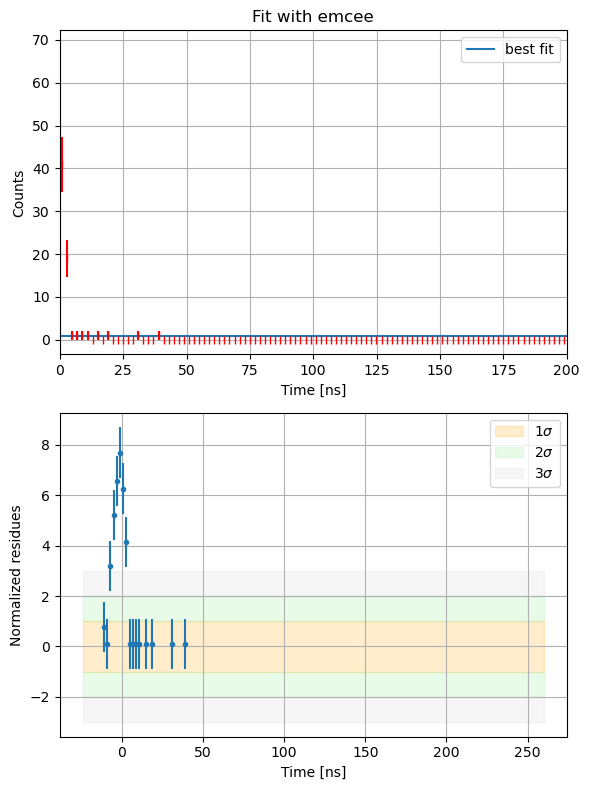

In [491]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(centers_btb, result_emcee_btb.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(centers_btb, bin_btb, err_btb, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residue_btb = bin_btb - result_emcee_btb.best_fit
norm_res_btb = residue_btb / err_btb

ax2.errorbar(centers_btb, norm_res_btb, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
#ax1.set_ylim(1, 1000)
ax1.set_title('Fit with emcee')
fig.tight_layout()

[[Model]]
    (Model(myexp, prefix='e1_') + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 118
    # variables        = 5
    chi-square         = 6460.22813
    reduced chi-square = 57.1701604
    Akaike info crit   = 482.322764
    Bayesian info crit = 496.176187
    R-squared          = 0.99970541
[[Variables]]
    e1_amplitude:  4815.44655 +/- 916.432493 (19.03%) (init = 1000)
    e1_decay:      1.65400687 +/- 0.23394752 (14.14%) (init = 100)
    g1_amplitude:  1082.82048 +/- 400.107275 (36.95%) (init = 1000)
    g1_center:     12.8307789 +/- 8.11959872 (63.28%) (init = 0)
    g1_sigma:      23.3216130 +/- 7.13793625 (30.61%) (init = 5)
    g1_fwhm:       54.9181999 +/- 16.8085551 (30.61%) == '2.3548200*g1_sigma'
    g1_height:     18.5228568 +/- 9.55450311 (51.58%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(e1_amplitude, e1_de

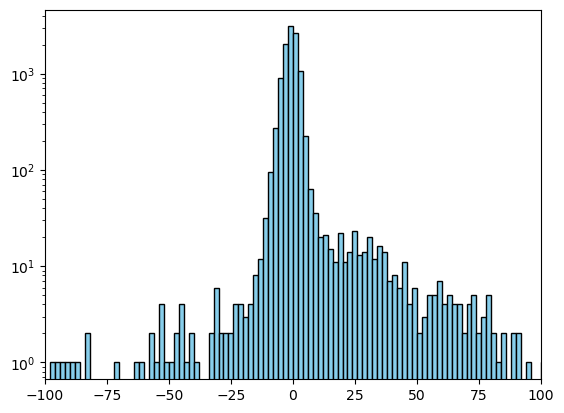

In [492]:
#isolo la componente a 3 fotoni

three_gamma_ortho=bin_T - bin_btb
three_gamma_edges=edgesT

three_gamma_ortho = three_gamma_ortho[3:]
three_gamma_edges = three_gamma_edges[3:]

#print(three_gamma_ortho, three_gamma_edges)
three_gamma_centers = np.convolve(three_gamma_edges, [0.5, 0.5], "valid")
three_g_err=np.sqrt(three_gamma_ortho)
plt.bar(three_gamma_edges[:-1], three_gamma_ortho, width=(three_gamma_edges[1] - three_gamma_edges[0]),align='edge', color='skyblue', edgecolor='black')
plt.xlim(-100,100)
plt.yscale('log')
exp1   = Model(myexp, independent_vars=['x'], prefix='e1_')
gauss1 = GaussianModel(prefix='g1_')
#gauss1 = VoigtModel(prefix='g1_')

model = exp1 + gauss1

params.update(gauss1.make_params(amplitude=1000, sigma=5, center=0))
params.update(exp1.make_params(amplitude=1000, decay=100))
params["e1_amplitude"].min = 0

result = model.fit(three_gamma_ortho, params, x = three_gamma_centers, weights = 1 / three_g_err,nan_policy='omit')

print(result.fit_report())

emcee_kws = dict(steps=5000, burn=500, thin=20, is_weighted=False,
                 progress=False)
emcee_params = result.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

result_emcee_3g = model.fit(data=three_gamma_ortho, x=three_gamma_centers, params=emcee_params, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)


In [493]:
print(result_emcee_3g.fit_report())

[[Model]]
    (Model(myexp, prefix='e1_') + Model(gaussian, prefix='g1_'))
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 500000
    # data points      = 240
    # variables        = 6
    chi-square         = 10072.4001
    reduced chi-square = 43.0444450
    Akaike info crit   = 908.859691
    Bayesian info crit = 929.743525
    R-squared          = 0.99954069
[[Variables]]
    e1_amplitude:  7063.65406 +/- 4735.86879 (67.05%) (init = 4815.447)
    e1_decay:      0.27191412 +/- 0.06361773 (23.40%) (init = 1.654007)
    g1_amplitude:  19932.6219 +/- 14.3903282 (0.07%) (init = 1082.82)
    g1_center:    -0.83140386 +/- 0.00226720 (0.27%) (init = 12.83078)
    g1_sigma:      2.62566456 +/- 0.00197716 (0.08%) (init = 23.32161)
    g1_fwhm:       6.18296741 == '2.3548200*g1_sigma'
    g1_height:     3028.55367 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    __lnsigma:     0.69306682 +/- 1.0756e-04 (0.02%) (init = -2.302585)
[[Correlations]] (unreported cor

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


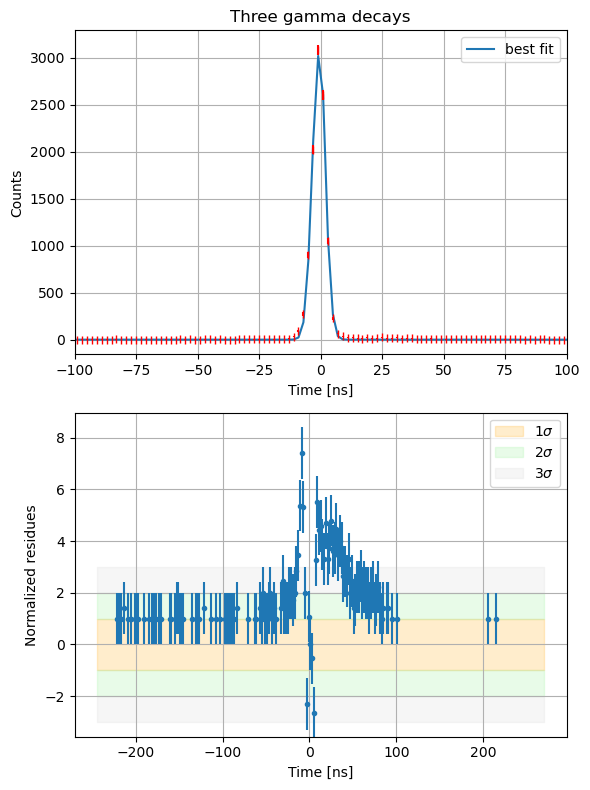

In [494]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

#comps = result_emcee.eval_components()                       
ax1.plot(three_gamma_centers, result_emcee_3g.best_fit, label='best fit')


ax1.legend()
ax1.errorbar(three_gamma_centers, three_gamma_ortho, three_g_err, color = "red", fmt='|')
ax1.set_xlim(-100, 100)
ax1.grid()

residue_3g = three_gamma_ortho - result_emcee_3g.best_fit
norm_res_3g = residue_3g / three_g_err

ax2.errorbar(three_gamma_centers, norm_res_3g, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()
ax1.set_title('Three gamma decays')
fig.tight_layout()

# Un po' di speculazioni da strutturista secondo il modello di Tao-Eldrup

In [495]:
delta = 0.166 #nm
lambdabar = 2.01 #ns^-1
lambda_po= 1/result_emcee_btb.params["e1_decay"].value #ns^-1
tau_po = result_emcee_btb.params["e1_decay"].value #ns
Rc = (tau_po + 5.07)/1.88
print(Rc)

-2.3806722239413648e+17


Original number of bins: 300
Symmetrized number of bins: 150
Filtered number of edges: 151
Final number of bins: 150
Final number of edges: 151


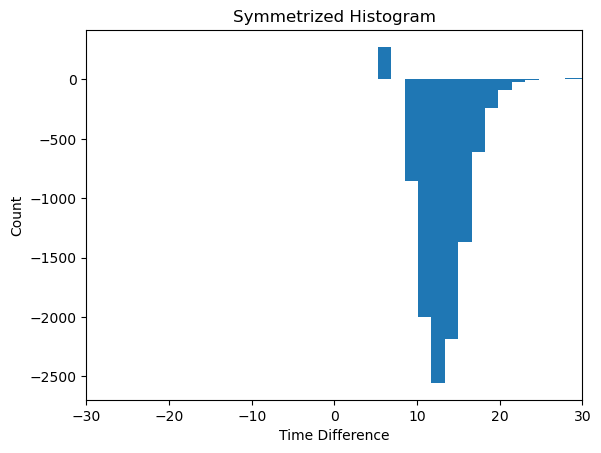

In [497]:

mean_time_diff = np.array([tdiff for tdiff in mean_time_diff if -300 < tdiff < 300])

# Compute the histogram with 300 bins
bin_T_new, edgesT_new, _ = plt.hist(mean_time_diff, bins=300)
plt.close()  # Close the plot to avoid displaying it

print(f'Original number of bins: {len(bin_T_new)}')

# Initialize the symmetrized bin list
bin_T_new_symmetrized = []

# Calculate the symmetrized bin counts by summing symmetric bins around the center
# Leaving the central bin unaltered
central_bin_index = 149
bin_T_new_symmetrized.append(bin_T_new[central_bin_index])
for i in range(central_bin_index):
    sym_value = (bin_T_new[central_bin_index + i] - bin_T_new[central_bin_index - i]) 
    bin_T_new_symmetrized.append(sym_value)  

print(f'Symmetrized number of bins: {len(bin_T_new_symmetrized)}')

# Filter the edges to keep only those that are non-negative
edgesT_new_filtered = edgesT_new[central_bin_index+1:]

print(f'Filtered number of edges: {len(edgesT_new_filtered)}')

print(f'Final number of bins: {len(bin_T_new_symmetrized)}')
print(f'Final number of edges: {len(edgesT_new_filtered)}')

# Plot the histogram using plt.bar
plt.bar(edgesT_new_filtered[:-1], bin_T_new_symmetrized, width=edgesT_new_filtered[1]-edgesT_new_filtered[0], align='edge')
plt.xlim(-30,30)
plt.xlabel('Time Difference')
plt.ylabel('Count')
plt.title('Symmetrized Histogram')
plt.show()

